# Imports and Dataset Fetching / Preprocessing functions


In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install ml_things
from ml_things import plot_confusion_matrix
from sklearn.metrics import classification_report, precision_recall_fscore_support
from statistics import mean

# Download necessary nltk stuff
nltk.download("punkt")
nltk.download('stopwords')
nltk.download('wordnet')


# preprocessing option flags - were never used but handy to keep
REMOVE_BOS_EOS = True
LOWERCASE_ALL_TEXT = True
REMOVE_PUNCTUATION = True
STEM = True
REMOVE_STOPWORDS = True


def preprocess(sentence):
  """
  Function used to preprocess a single sentence. preprocessing steps can be enabled/disabled using the above flags.
  """
    # Remove <BOS> and <EOS>
    if REMOVE_BOS_EOS:
        sentence = sentence.replace('<EOS>', '')
        sentence = sentence.replace('<BOS>', '')

    # Lowercase all text
    if LOWERCASE_ALL_TEXT:
        sentence = sentence.lower()

    # Tokenize Text
    words = word_tokenize(sentence)

    # Remove Stopwords
    if REMOVE_STOPWORDS:
        stop_words = set(stopwords.words('english'))
        words = [word for word in words if word not in stop_words]

    # Remove Punctuation
    if REMOVE_PUNCTUATION:
        words = [word for word in words if word.isalnum()]

    # Stem and Lemmatise text
    if STEM:
        ps = PorterStemmer()
        lemmatizer = WordNetLemmatizer()
        words = [ps.stem(word) for word in words]

    return words


def preprocess_df(df):
  """
  Preprocesses a dataframe.
  """
  df['preprocessed'] = df['tagged_in_context'].apply(preprocess) # Preprocess dataset
  df.drop(columns=['tagged_in_context'], inplace=True) # Drop un-preprocessed data
  df['word-count'] = df['preprocessed'].apply(len) # Get lengths of each preprocessed sentence.

  return df

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 13.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 3.3 MB/s eta 0:00:00
  Created wheel for ml_things: filename=ml_things-0.0.1-py3-none-any.whl size=24393 sha256=c8e1f7569b432e222f44e67767f6f58024fcdad6d270a5677ce1056d4a2bf331
  Stored in directory: /root/.cache/pip/wheels/2a/b9/36/3725744c1d8ebec00cd847c9461b4352ce08de9d3f20b6bdcf
Successfully built ml_things


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# Load and preprocess Datasets into Dataframes





In [ ]:

# root directory for GDrive
ROOT_DIR = '/content/drive/MyDrive/ANLE_Coursework/Data/'

# Create training and testing dataframes from tsv files
df_train = pd.read_csv(ROOT_DIR + 'propaganda_train.tsv', delimiter="\t")
df_test = pd.read_csv(ROOT_DIR + 'propaganda_val.tsv', delimiter="\t")


# Replace all propaganda classes with one generalised "propaganda" class.
df_train['label'] = df_train['label'].mask(df_train['label'] != 'not_propaganda', 'propaganda')
df_test['label'] = df_test['label'].mask(df_test['label'] != 'not_propaganda', 'propaganda')


# Preprocess training Dataframe
df_train = preprocess_df(df_train)
# Remove Bugged TSV Rows with multiple spans
df_train = df_train.drop(index=[783, 1999, 2022, 1573])

# Split training dataframe into propaganda and not-propaganda dataframes
df_train_prop = df_train[df_train['label'] == 'propaganda'].copy()
df_train_not_prop = df_train[df_train['label'] == 'not_propaganda'].copy()

# preprocess testing dataframe
df_test = preprocess_df(df_test)
# remoe bugged tsv rows from testing df.
df_test = df_test.drop(index=[293,314,420])


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Unigrams

## Unigram Class

In [ ]:
from collections import Counter
from sklearn.metrics import confusion_matrix
from math import log


class UnigramModel():
  """
  Class for a unigram Modeller.

  Arguments:

      is_propaganda: used to pick if the model should use the propaganda or non_propaganda DF.

      default_probability_value: the default value to use if a unigram is unseen in the test corpus.
  """

  def __init__(self, is_propaganda: bool, default_probability_value):

    if is_propaganda:
      # Get propaganda dataset as a list
      dataset = df_train_prop['preprocessed'].tolist()

    else:
      # Get non-propaganda dataset as a list
      dataset = df_train_not_prop['preprocessed'].tolist()

    # create counter and tracking variable
    unigram_counts = Counter()
    total_words = 0

    # count unigrams & total words
    for sentence in dataset:
      unigram_counts.update(sentence)
      total_words += len(sentence)

    # create unigram model
    self.unigram_probabilities = {word: count/total_words for word, count in unigram_counts.items()}

    # store default probability
    self.default_probability_value = default_probability_value
    return


  def get_word_probability(self, word):
    """
    Gets the probability of a word
    Args:
        word: the word to get the probability of
    """
    return self.unigram_probabilities.get(word, self.default_probability_value)


  def get_sentence_probability(self, preprocessed_sentence):
    """
      gets the sentence log probability of a preprocessed sentence

      Args:
          preprocessed_sentence: the sentence to get the probability of.
    """

    #Tracking varibale
    total_probability = 0

    # get the total log probability by summing each word's log prob.
    for word in preprocessed_sentence:
      try:
        total_probability += log(self.get_word_probability(word)) # Get word if it exists, inner fn call handles unseen unigrams with default value
      except ValueError:
        print("") # Do nothing if an error occurs

    return total_probability



def classify(propaganda_model, non_propaganda_model, preprocessed_sentence):
  """
  Classifies a sentence as propaganda or not propaganda based on two supplied models.
  Args:
      propaganda_model: the propaganda model to use
      non_propaganda_model: the non-propaganda model to use
      preprocessed_sentence: the preprocessed sentence to classify
  """

  # Get propaganda probability
  propaganda_probability = propaganda_model.get_sentence_probability(preprocessed_sentence)

  # get non-propaganda probability
  not_propaganda_probability = non_propaganda_model.get_sentence_probability(preprocessed_sentence)

  # return the class of the higher probability model.
  if propaganda_probability > not_propaganda_probability:
    return "propaganda" # propaganda model has higher probability
  else:
    return "not_propaganda" # non-propaganda model has higher probability.




/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Test Unigram Model

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:646: DeprecationWarning: `title` will be deprecated in future updates. Use `use_title` in stead!
  warnings.warn("`title` will be deprecated in future updates. Use `use_title` in stead!", DeprecationWarning)


Confusion matrix, without normalization


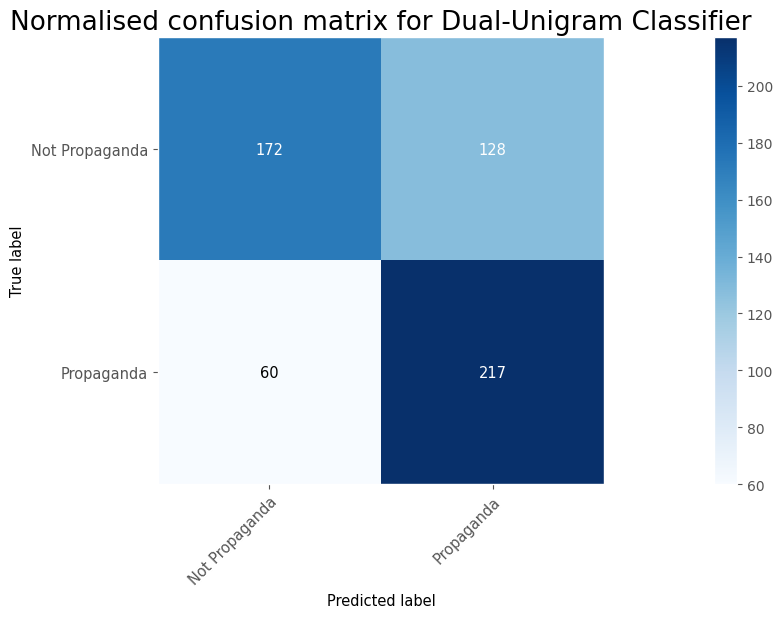

/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:646: DeprecationWarning: `title` will be deprecated in future updates. Use `use_title` in stead!
  warnings.warn("`title` will be deprecated in future updates. Use `use_title` in stead!", DeprecationWarning)


Confusion matrix, without normalization


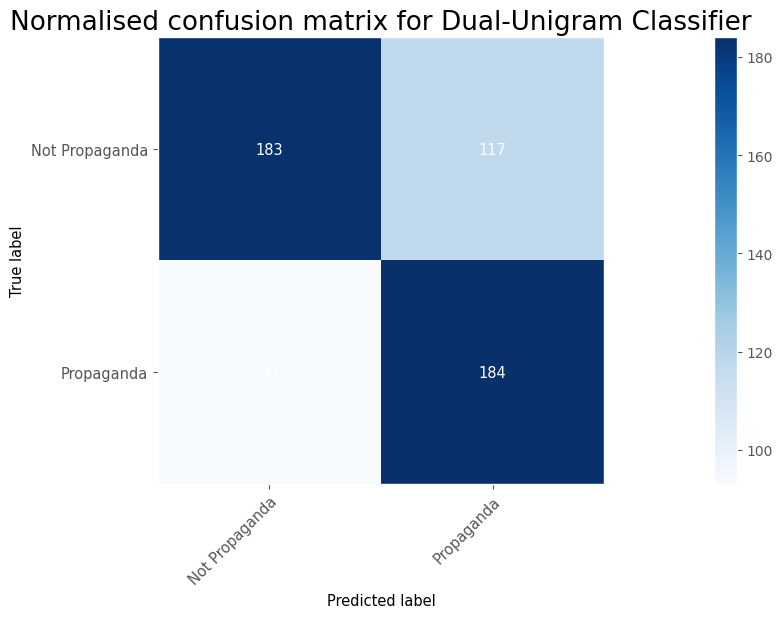

/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:646: DeprecationWarning: `title` will be deprecated in future updates. Use `use_title` in stead!
  warnings.warn("`title` will be deprecated in future updates. Use `use_title` in stead!", DeprecationWarning)


Confusion matrix, without normalization


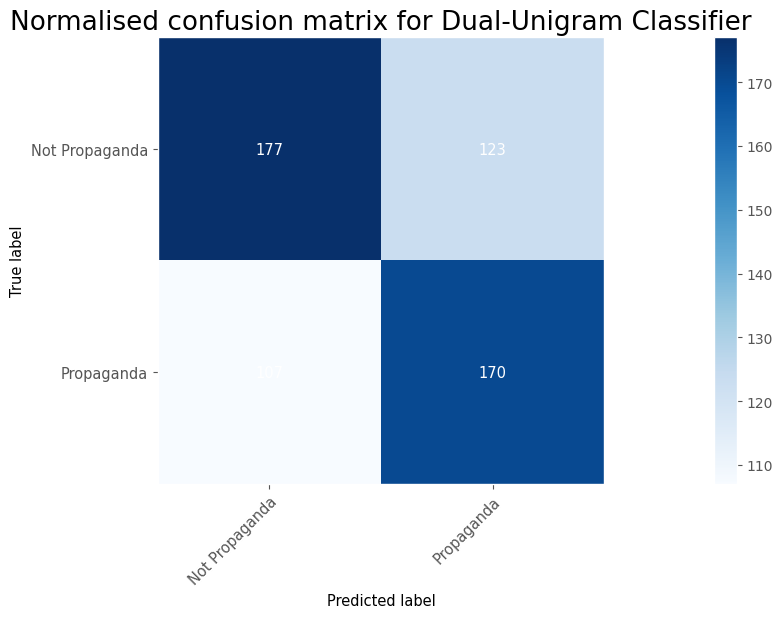

/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:646: DeprecationWarning: `title` will be deprecated in future updates. Use `use_title` in stead!
  warnings.warn("`title` will be deprecated in future updates. Use `use_title` in stead!", DeprecationWarning)


Confusion matrix, without normalization


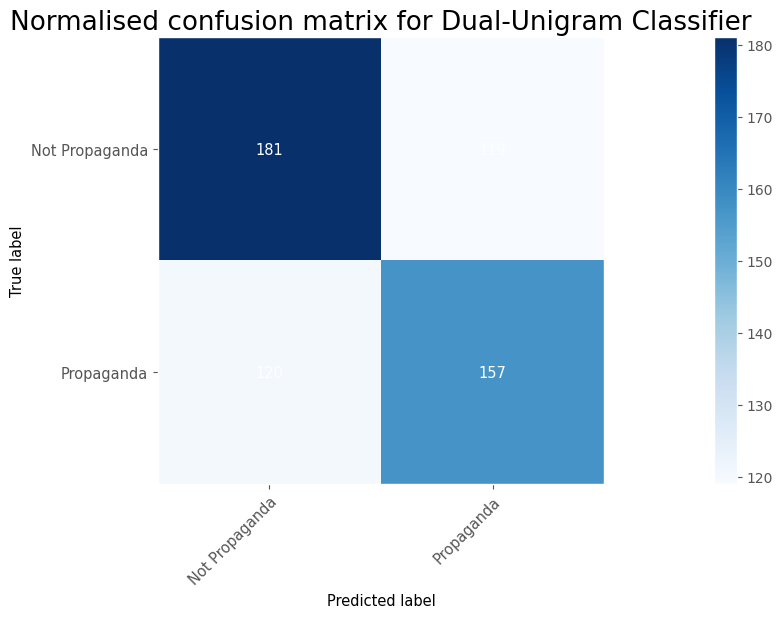

/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:646: DeprecationWarning: `title` will be deprecated in future updates. Use `use_title` in stead!
  warnings.warn("`title` will be deprecated in future updates. Use `use_title` in stead!", DeprecationWarning)


Confusion matrix, without normalization


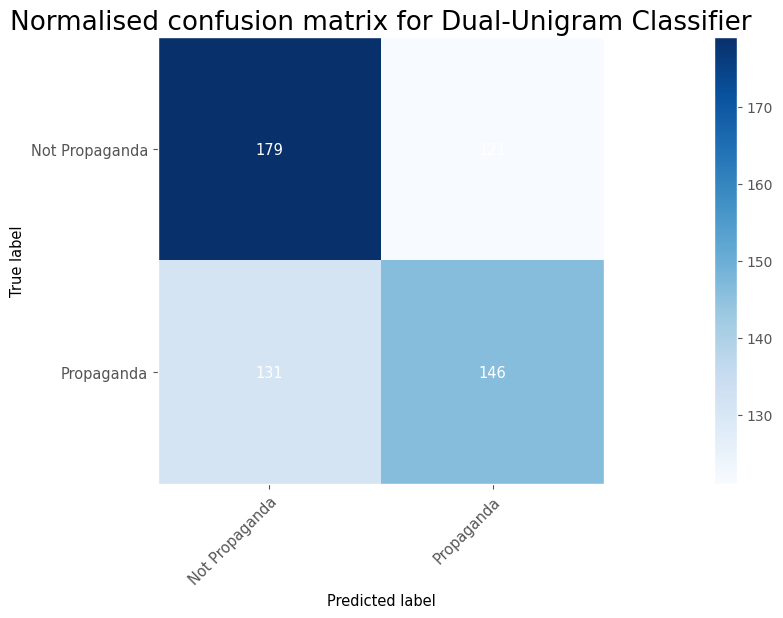

/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:646: DeprecationWarning: `title` will be deprecated in future updates. Use `use_title` in stead!
  warnings.warn("`title` will be deprecated in future updates. Use `use_title` in stead!", DeprecationWarning)


Confusion matrix, without normalization


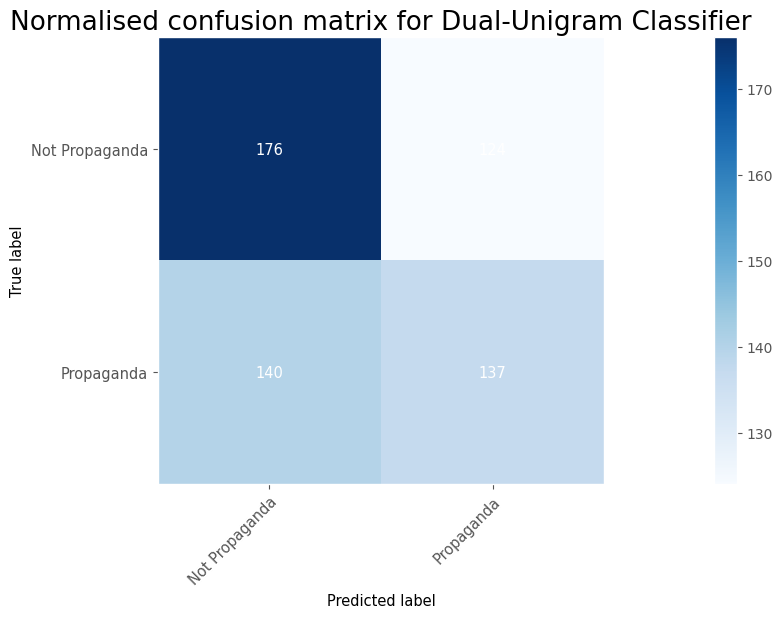

/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:646: DeprecationWarning: `title` will be deprecated in future updates. Use `use_title` in stead!
  warnings.warn("`title` will be deprecated in future updates. Use `use_title` in stead!", DeprecationWarning)


Confusion matrix, without normalization


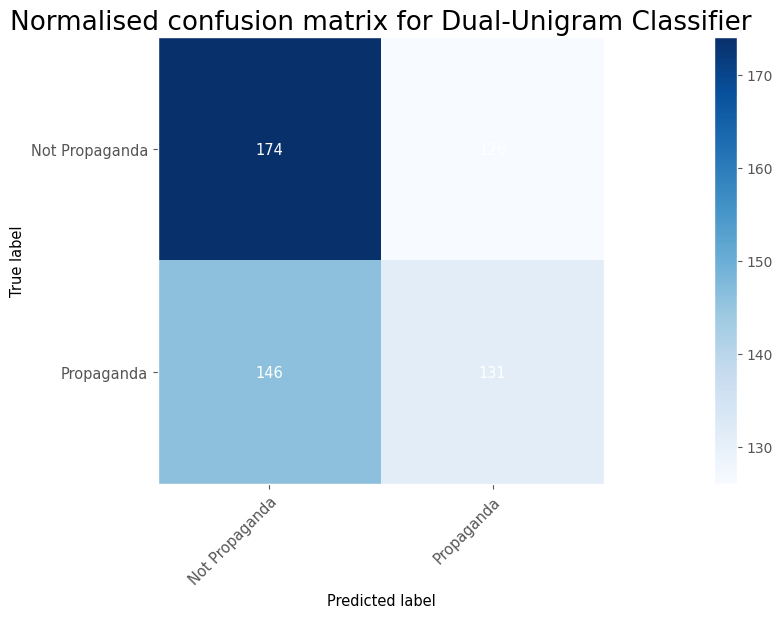

/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:646: DeprecationWarning: `title` will be deprecated in future updates. Use `use_title` in stead!
  warnings.warn("`title` will be deprecated in future updates. Use `use_title` in stead!", DeprecationWarning)


Confusion matrix, without normalization


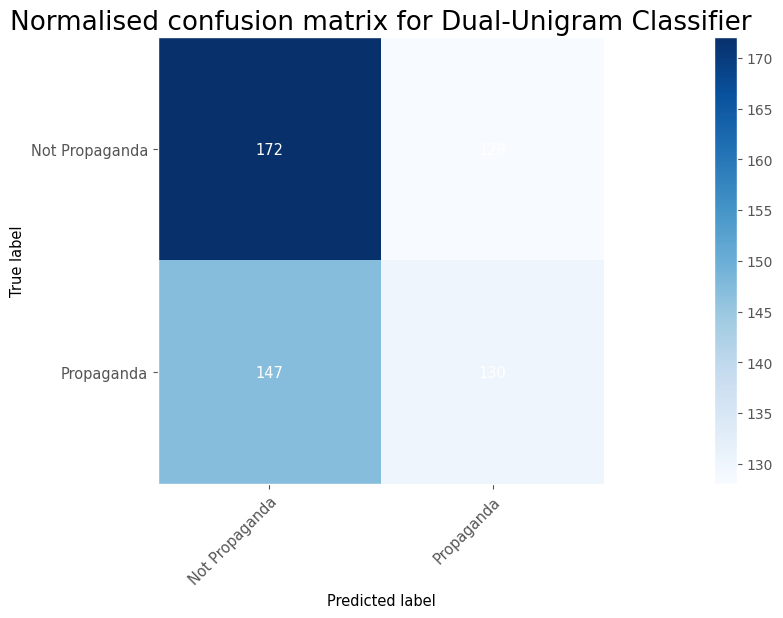

/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:646: DeprecationWarning: `title` will be deprecated in future updates. Use `use_title` in stead!
  warnings.warn("`title` will be deprecated in future updates. Use `use_title` in stead!", DeprecationWarning)


Confusion matrix, without normalization


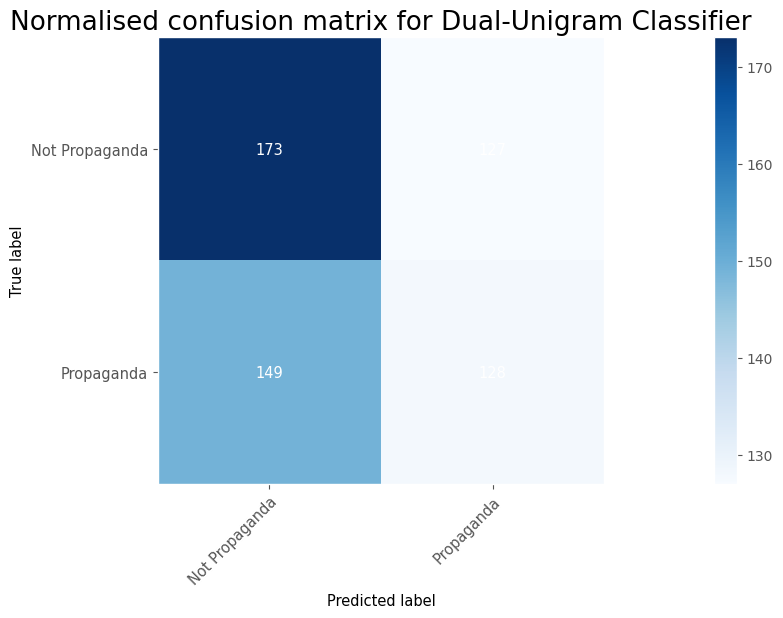

/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:646: DeprecationWarning: `title` will be deprecated in future updates. Use `use_title` in stead!
  warnings.warn("`title` will be deprecated in future updates. Use `use_title` in stead!", DeprecationWarning)


Confusion matrix, without normalization


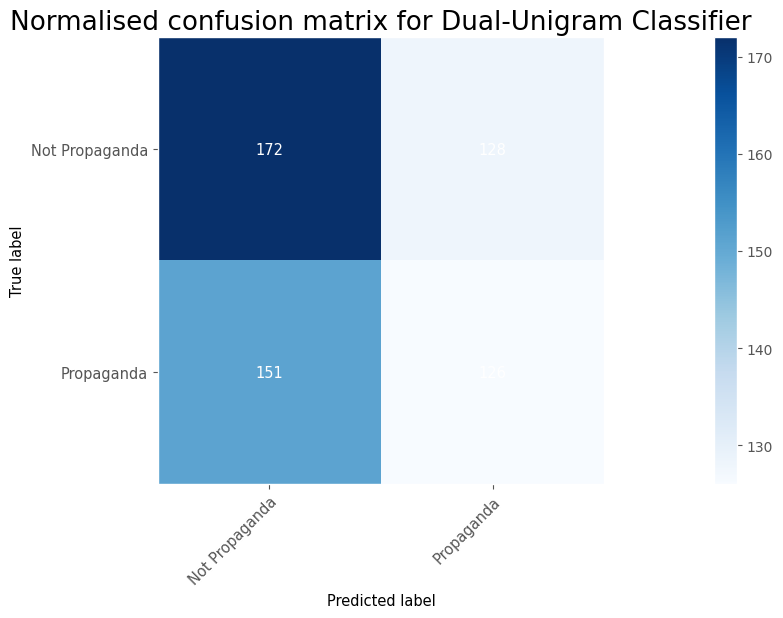

/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:646: DeprecationWarning: `title` will be deprecated in future updates. Use `use_title` in stead!
  warnings.warn("`title` will be deprecated in future updates. Use `use_title` in stead!", DeprecationWarning)


Confusion matrix, without normalization


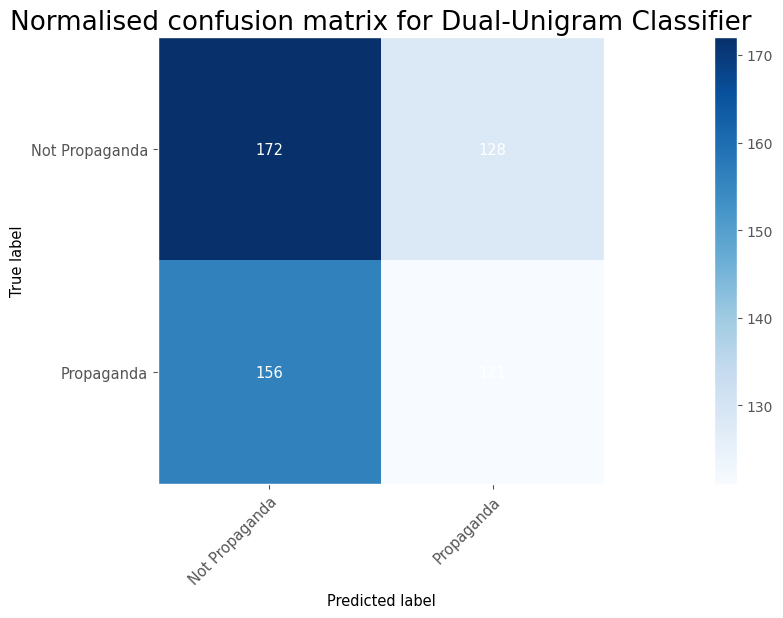

Highest default value is: 1e-10 with F1-score: 0.6721828687474313


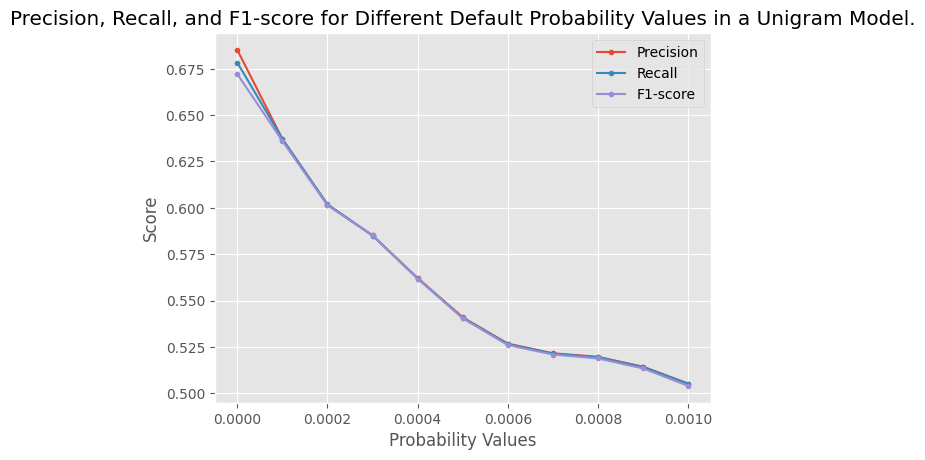

[0.5051670095014203, 0.505078219013237, 0.5039233731321595]

In [ ]:
# Initialise tracking varibale, scores are kept in here.
experiment_scores = {}

# Differnet default values to test.
default_values = [0.0000000001, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001]

# For each default value, classify test set.
for def_value in default_values:

  # Create propaganda model
  propaganda_unigram_modeller = UnigramModel(is_propaganda=True, default_probability_value=def_value)

  # Create non-propaganda model.
  non_propaganda_unigram_modeller = UnigramModel(is_propaganda=False, default_probability_value=def_value)


  # Get true labels
  true_labels = df_test['label']
  # init list to track predicted labels
  predicted_labels = []

  # Create a classification for each sentence in the test set.
  for test_sentence in df_test['preprocessed']:
    prediction = classify(propaganda_unigram_modeller, non_propaganda_unigram_modeller, test_sentence)
    predicted_labels.append(prediction)

  # plot a confusion matrix from the true vs predicted labels
  plot_confusion_matrix(y_true=true_labels, y_pred=predicted_labels, classes=["Not Propaganda", "Propaganda"], normalize=False, title="Normalised confusion matrix for Dual-Unigram Classifier", magnify=0.1)

  # Calculate metrics
  precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels)
  precision = mean(precision)
  recall = mean(recall)
  f1_score = mean(f1_score)

  # save experiment metrics.
  experiment_scores[def_value] = [precision, recall, f1_score]



# Extract precision, recall, and F1-score values
probabilities = list(experiment_scores.keys())
precision_values = [metrics[0] for metrics in experiment_scores.values()]
recall_values = [metrics[1] for metrics in experiment_scores.values()]
f1_score_values = [metrics[2] for metrics in experiment_scores.values()]

# Get the highest F1 score and the associated default value.
max_index = f1_score_values.index(max(f1_score_values))
print(f"Highest default value is: {default_values[max_index]} with F1-score: {max(f1_score_values)}" )

# Plot precision, recall, and F1-score
plt.plot(probabilities, precision_values, marker='.', label='Precision')
plt.plot(probabilities, recall_values, marker='.', label='Recall')
plt.plot(probabilities, f1_score_values, marker='.', label='F1-score')

#add labels and legend
plt.xlabel('Probability Values')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-score for Different Default Probability Values in a Unigram Model.')
plt.legend()

#show plot
plt.grid(True)
plt.show()


unigram_f1_scores = f1_score_values

experiment_scores[0.001]

In [ ]:
# Testing the number of unseen words for each class, may help explain results
test_model_prop = UnigramModel(True, 123)
test_model_no = UnigramModel(False, 123)
num_of_unseen_prop = 0
num_of_unseen_no = 0
word_count = 0
for sentence in df_test['preprocessed']:
  for word in sentence:
    word_count+= 1
    if test_model_prop.get_word_probability(word) == 123:
      num_of_unseen_prop += 1
    if test_model_no.get_word_probability(word) == 123:
      num_of_unseen_no += 1


print(f"Number of unseen words in propaganda test set: {(num_of_unseen_prop/word_count)*100}%")
print(f"Number of unseen words in non-propaganda test set: {(num_of_unseen_no/word_count*100)}%")

Number of unseen words in propaganda test set: 12.282169245782796%
Number of unseen words in non-propaganda test set: 15.600167294019238%


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Bigrams

##Create Bigram Class

In [ ]:
from nltk import bigrams

class BigramModel():
  """
  Class for a bigram Modeller.

  Arguments:

      is_propaganda: used to pick if the model should use the propaganda or non_propaganda DF.

      default_probability_value: the default value to use if a biigram is unseen in the test corpus.
  """

  def __init__(self, is_propaganda: bool, default_probability_value):
    # Save default probability value to instance.
    self.default_probability_value = default_probability_value

    # Turn sentence into dataset and add start/end tokens
    if is_propaganda:
      # create propaganda list dataset.
      dataset = df_train_prop['preprocessed'].tolist()
      # Add start and end tokens to allow all words to be checked.
      dataset = [ ["<START>"] + sentence + ["<END>"] for sentence in dataset]

    else:
      # create non-propaganda list dataset
      dataset = df_train_not_prop['preprocessed'].tolist()
      # Add start and end tokens to allow all words to be checked.
      dataset = [ ["<START>"] + sentence + ["<END>"] for sentence in dataset]

    # get all tokens
    all_tokens = [token for sentence in dataset for token in sentence]

    # get vocabulary size
    self.vocabulary_size = len(set(all_tokens))


    #create bigrams and count them
    bigrams = list(nltk.bigrams(all_tokens))
    bigram_counts = Counter(bigrams)

    #init bigram model
    self.bigram_model = {}

      # create bigrams
    for bigram, count in bigram_counts.items():
      prev_token = bigram[0]
      if prev_token not in self.bigram_model: # case of unseen bigram
          self.bigram_model[prev_token] = {} # create dict and add it
      self.bigram_model[prev_token][bigram[1]] = count / (all_tokens.count(prev_token))
    return

  def get_bigram_probability(self, word1, word2):
    """
    Gets the probability of a word, given a previous word.
    """
    return self.bigram_model.get(word1, {}).get(word2,self.default_probability_value) # Get value. if there isn't a value, return the default probability.

  def get_sentence_probability(self,preprocessed_sentence):
    """
    Gets a sentence's log probability based on the bigram modeller.
    """
    # Create bigrams from sentence
    bigrams = list(nltk.bigrams(preprocessed_sentence))
    # tracking vairbale
    total_log_probability = 0
    # sum each bigram's log probability
    for (word1, word2) in bigrams:
      total_log_probability += log(self.get_bigram_probability(word1, word2))
    return total_log_probability


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Test Bigram Model

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:646: DeprecationWarning: `title` will be deprecated in future updates. Use `use_title` in stead!
  warnings.warn("`title` will be deprecated in future updates. Use `use_title` in stead!", DeprecationWarning)


Normalized confusion matrix


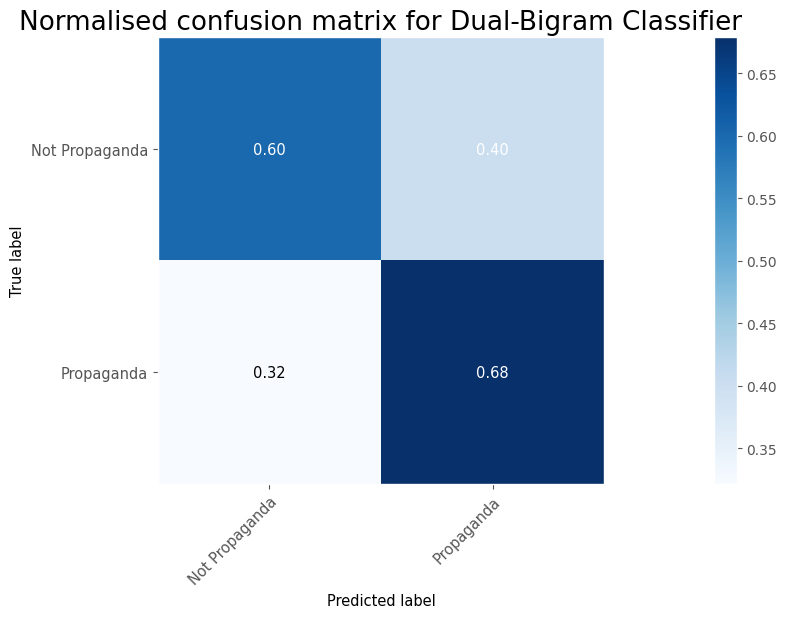

/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:646: DeprecationWarning: `title` will be deprecated in future updates. Use `use_title` in stead!
  warnings.warn("`title` will be deprecated in future updates. Use `use_title` in stead!", DeprecationWarning)


Normalized confusion matrix


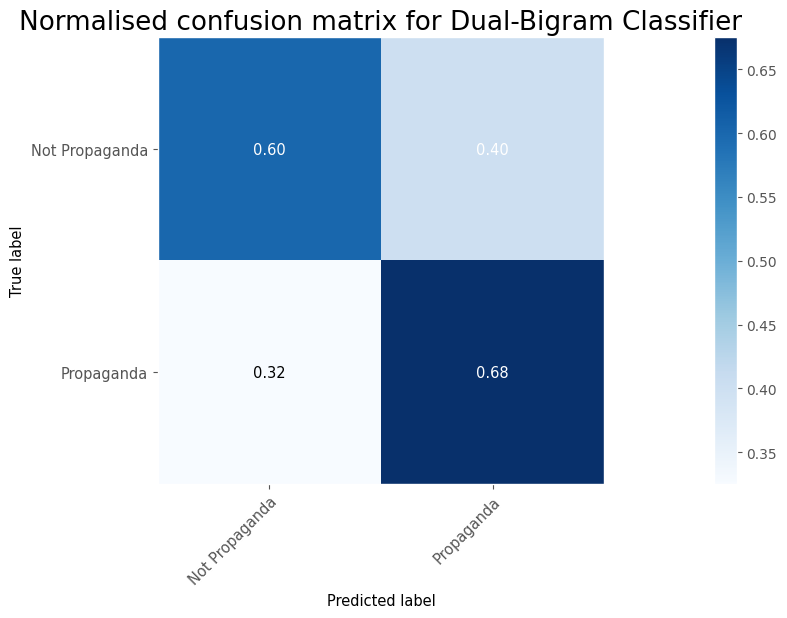

/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:646: DeprecationWarning: `title` will be deprecated in future updates. Use `use_title` in stead!
  warnings.warn("`title` will be deprecated in future updates. Use `use_title` in stead!", DeprecationWarning)


Normalized confusion matrix


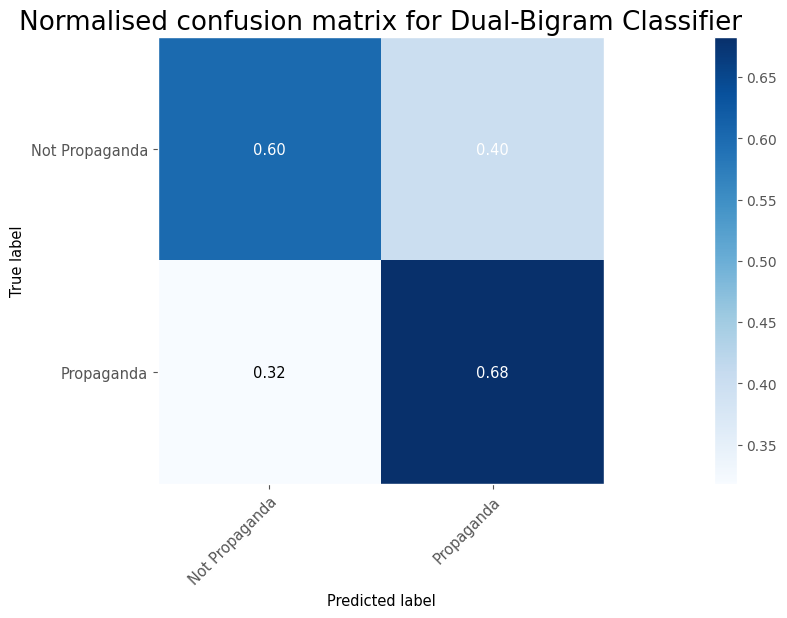

/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:646: DeprecationWarning: `title` will be deprecated in future updates. Use `use_title` in stead!
  warnings.warn("`title` will be deprecated in future updates. Use `use_title` in stead!", DeprecationWarning)


Normalized confusion matrix


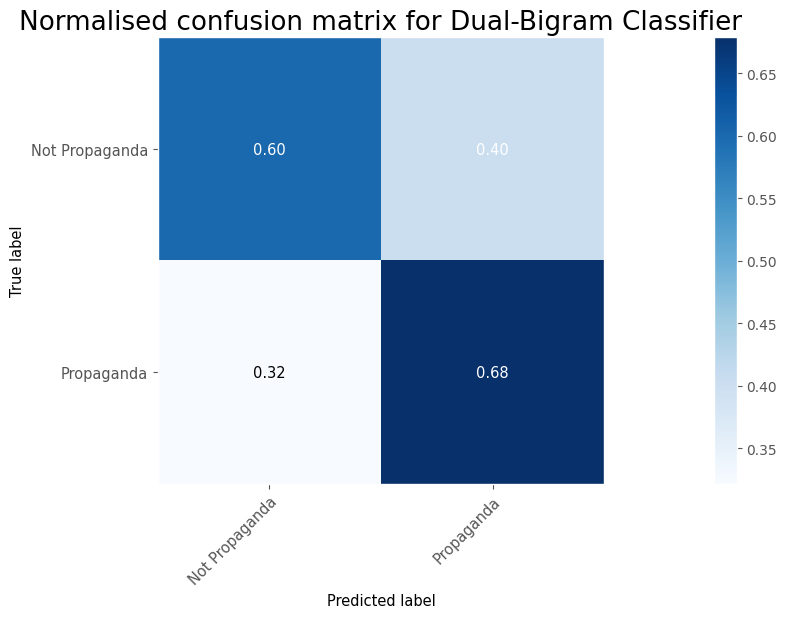

/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:646: DeprecationWarning: `title` will be deprecated in future updates. Use `use_title` in stead!
  warnings.warn("`title` will be deprecated in future updates. Use `use_title` in stead!", DeprecationWarning)


Normalized confusion matrix


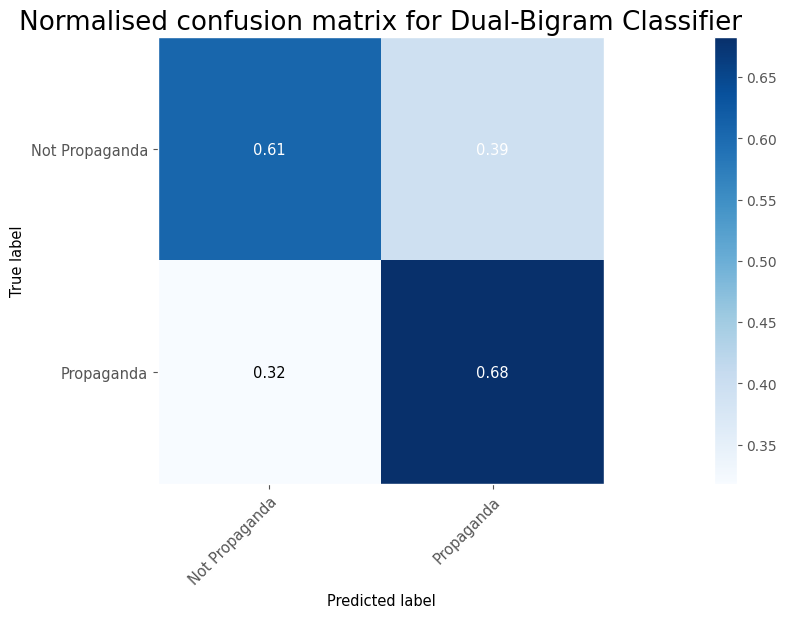

/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:646: DeprecationWarning: `title` will be deprecated in future updates. Use `use_title` in stead!
  warnings.warn("`title` will be deprecated in future updates. Use `use_title` in stead!", DeprecationWarning)


Normalized confusion matrix


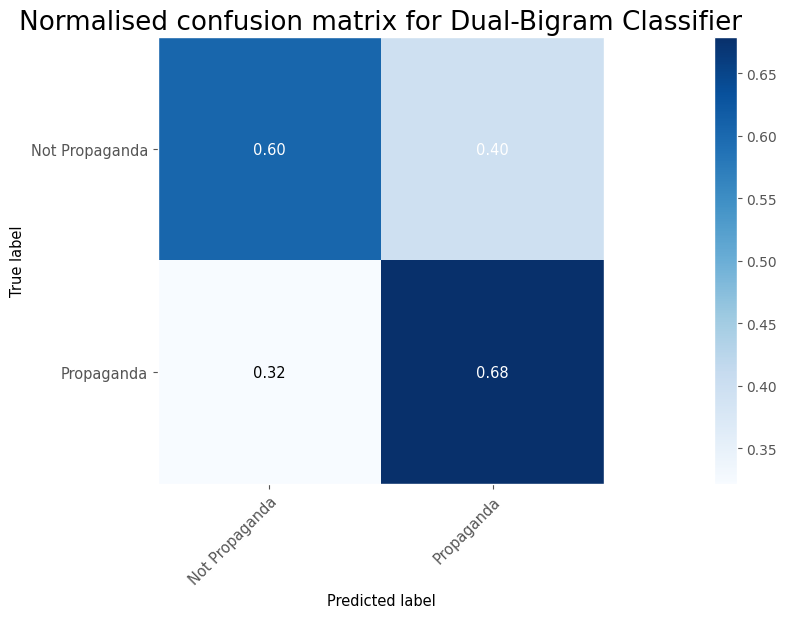

/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:646: DeprecationWarning: `title` will be deprecated in future updates. Use `use_title` in stead!
  warnings.warn("`title` will be deprecated in future updates. Use `use_title` in stead!", DeprecationWarning)


Normalized confusion matrix


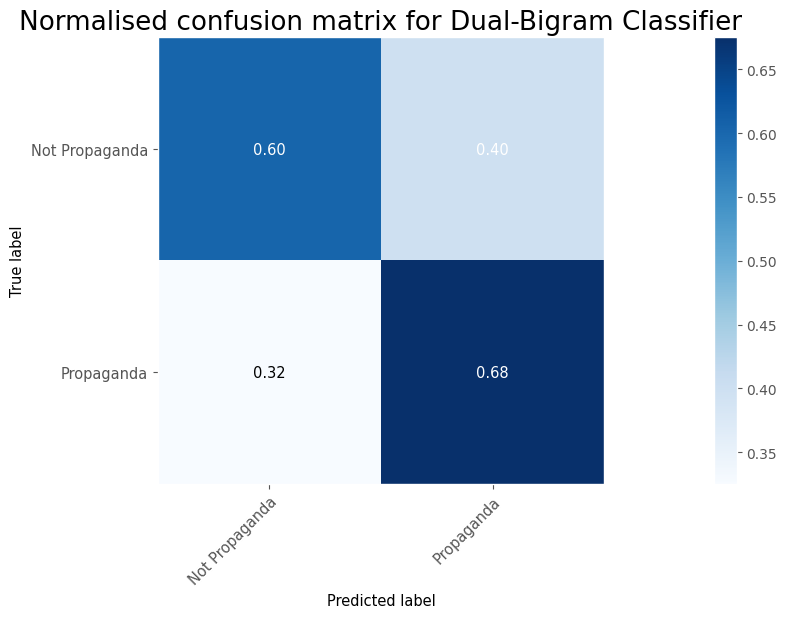

/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:646: DeprecationWarning: `title` will be deprecated in future updates. Use `use_title` in stead!
  warnings.warn("`title` will be deprecated in future updates. Use `use_title` in stead!", DeprecationWarning)


Normalized confusion matrix


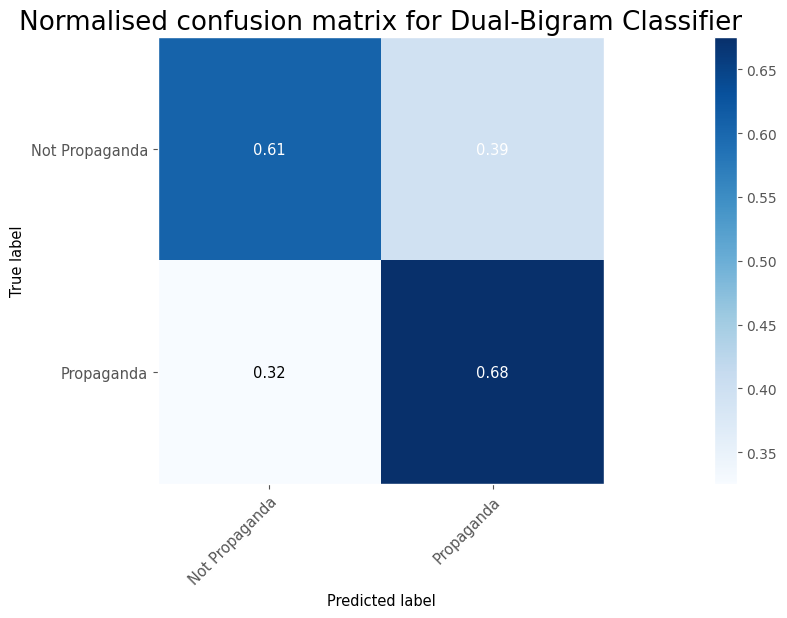

/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:646: DeprecationWarning: `title` will be deprecated in future updates. Use `use_title` in stead!
  warnings.warn("`title` will be deprecated in future updates. Use `use_title` in stead!", DeprecationWarning)


Normalized confusion matrix


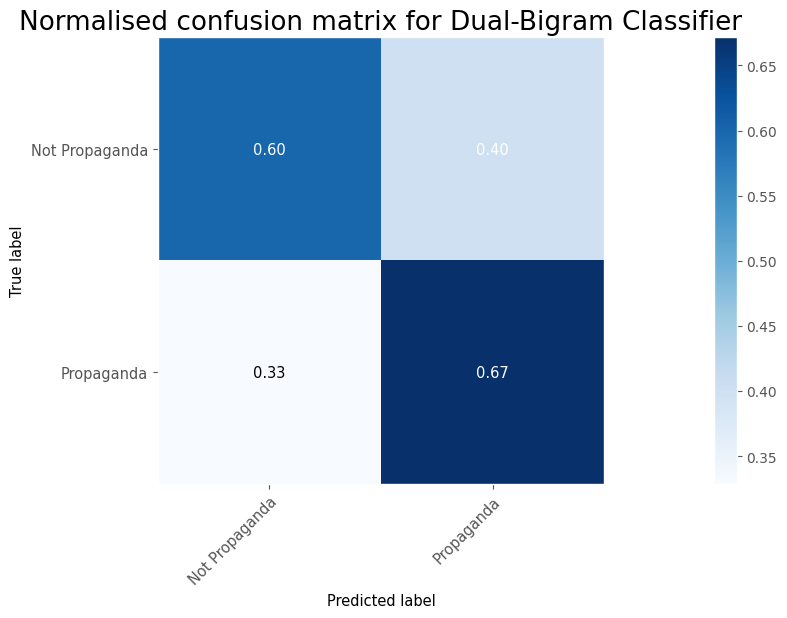

/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:646: DeprecationWarning: `title` will be deprecated in future updates. Use `use_title` in stead!
  warnings.warn("`title` will be deprecated in future updates. Use `use_title` in stead!", DeprecationWarning)


Normalized confusion matrix


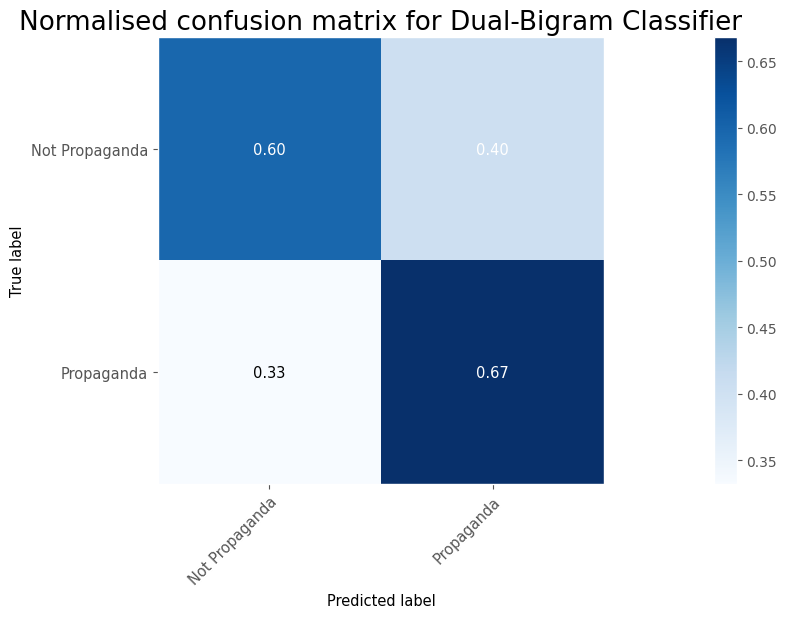

/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:646: DeprecationWarning: `title` will be deprecated in future updates. Use `use_title` in stead!
  warnings.warn("`title` will be deprecated in future updates. Use `use_title` in stead!", DeprecationWarning)


Normalized confusion matrix


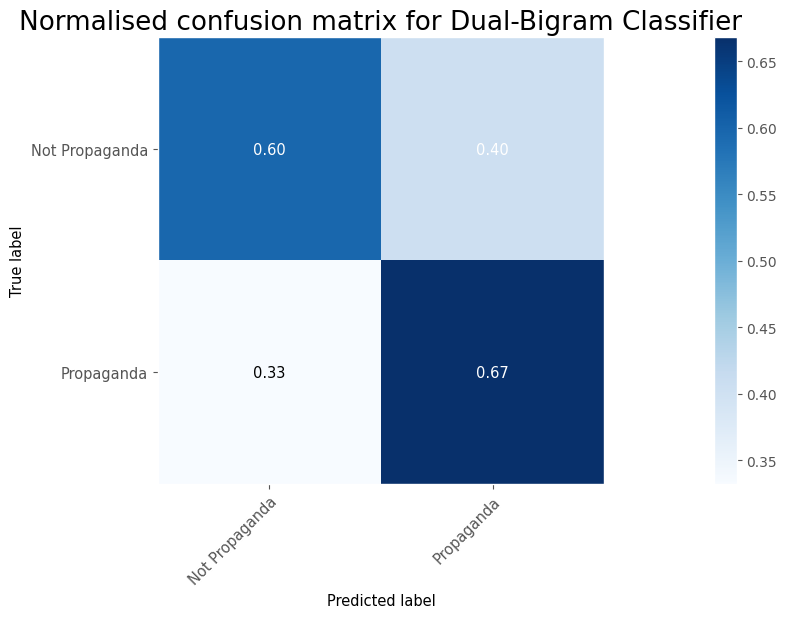

Highest default value is: 0.0004 with F1-score: 0.6429283826003365


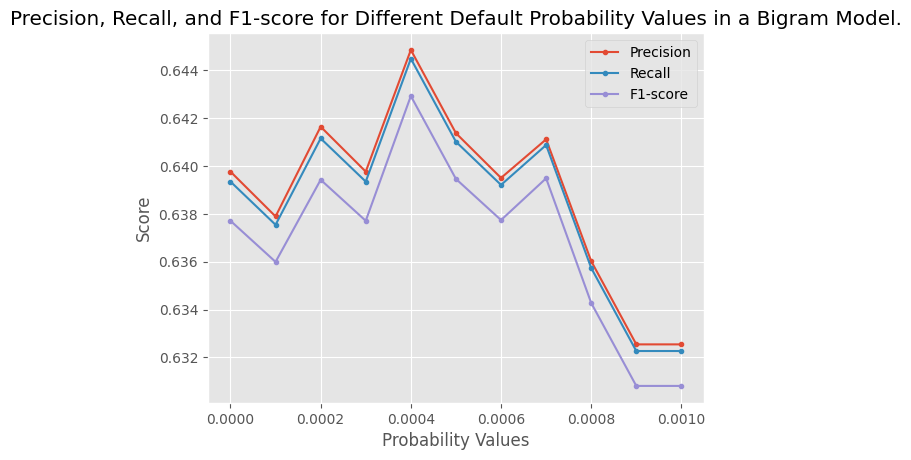

In [ ]:
# Initialise tracking varibale, scores are kept in here.
experiment_scores = {}

# init differnet default values
default_values = [0.0000000001, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001]

# For each default value, classify test set.
for def_value in default_values:


  # create propaganda model
  propaganda_bigram_modeller = BigramModel(is_propaganda=True, default_probability_value = def_value)
  # create non propaganda model
  non_propaganda_bigram_modeller = BigramModel(is_propaganda=False, default_probability_value = def_value)

  # get true labels
  true_labels = df_test['label']

  # init prediction list
  predicted_labels = []

  # add tokens to test sentences
  test_sentences = [ ["<START>"] + sentence + ["<END>"] for sentence in list(df_test['preprocessed'])]

  #classify each sentence
  for test_sentence in test_sentences:
    prediction = classify(propaganda_bigram_modeller, non_propaganda_bigram_modeller, test_sentence)
    predicted_labels.append(prediction)

  # plot confusion matrix of true labels vs predicted labels
  plot_confusion_matrix(y_true=true_labels, y_pred=predicted_labels, classes=["Not Propaganda", "Propaganda"], normalize=True, title="Normalised confusion matrix for Dual-Bigram Classifier", magnify=0.1)

  #collect metrics
  precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels)
  precision = mean(precision)
  recall = mean(recall)
  f1_score = mean(f1_score)

  # save metrics
  experiment_scores[def_value] = [precision, recall, f1_score]



#get precision, recall, and F1-score values
probabilities = list(experiment_scores.keys())
precision_values = [metrics[0] for metrics in experiment_scores.values()]
recall_values = [metrics[1] for metrics in experiment_scores.values()]
f1_score_values = [metrics[2] for metrics in experiment_scores.values()]

max_index = f1_score_values.index(max(f1_score_values))
print(f"Highest default value is: {default_values[max_index]} with F1-score: {max(f1_score_values)}" )

#plot precision, recall, and F1-score
plt.plot(probabilities, precision_values, marker='.', label='Precision')
plt.plot(probabilities, recall_values, marker='.', label='Recall')
plt.plot(probabilities, f1_score_values, marker='.', label='F1-score')

#add labels and legend
plt.xlabel('Probability Values')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-score for Different Default Probability Values in a Bigram Model.')
plt.legend()

# plot everything
plt.grid(True)
plt.show()

bigram_f1_scores = f1_score_values

In [ ]:
# Testing the number of unseen words for each class, may help explain results


test_model_prop = BigramModel(True, 123)
test_model_no = BigramModel(False, 123)
num_of_unseen_prop = 0
num_of_unseen_no = 0
word_count = 0
for sentence in df_test['preprocessed']:
  sentence = ["<START>"] + sentence + ["<END>"]
  for i in range(len(sentence)-1):
    word1 = sentence[i]
    word2 = sentence[i+1]

    word_count+= 1
    if test_model_prop.get_bigram_probability(word1, word2) == 123:
      num_of_unseen_prop += 1
    if test_model_no.get_bigram_probability(word1, word2) == 123:
      num_of_unseen_no += 1


print(f"Number of unseen Bigrams in propaganda test set: {(num_of_unseen_prop/word_count)*100}%")
print(f"Number of unseen Bigrams in non-propaganda test set: {(num_of_unseen_no/word_count*100)}%")

Number of unseen Bigrams in propaganda test set: 74.70967741935483%
Number of unseen Bigrams in non-propaganda test set: 83.79354838709678%


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Find final values

In [ ]:
# get final F1 scores for tables
print(unigram_f1_scores)
print()
print(bigram_f1_scores)

[0.6721828687474313, 0.636047433679354, 0.6013278058159095, 0.585070692907842, 0.5618249758919962, 0.5403611258629846, 0.5259635133502476, 0.520858182477013, 0.5187365519909097, 0.5133716026879235, 0.5039233731321595]

[0.6377119853394018, 0.6359949531362653, 0.6394270057203287, 0.6377119853394018, 0.6429283826003365, 0.6394616678683009, 0.6377424577867363, 0.6394876601062168, 0.6342758784354132, 0.6308092990840901, 0.6308092990840901]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
